In [1]:

import numpy as np # used for handling numbers
import pandas as pd # used for handling the dataset
from sklearn.impute import SimpleImputer # used for handling missing data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # used for encoding categorical data
from sklearn.model_selection import train_test_split # used for splitting training and testing data
from sklearn.preprocessing import StandardScaler # used for feature scaling



import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.utils import shuffle



from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error



#reading the dataset
df = pd.read_csv('10_data_trimed_attack_noAttack.csv')

def read_dataset():
    #print
    X = df[df.columns[0:42]].values
    y = df[df.columns[41]]
    
    
    #encode the dependant variable
    Y = one_hot_encode(y)
    print(X.shape)
    print(Y.shape)
    return(X,Y)

#define one-hot-encoder function
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels, n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

#Read the dataset
X, Y = read_dataset()

#shufffle the dataset to mix up the rows
X,Y = shuffle(X, Y,random_state = 1)

#dataset into train & test 
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.20, random_state=415)

#shapes of the training and testing
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

#define the important parameters and variables to work with the tensors
initial_learning_rate = 0.3
decay_steps = 10000
decay_rate = 0.96
training_epochs = 100
cost_history = np.empty(shape=[1], dtype=float)
n_dim = X.shape[1]
print("n_dim", n_dim)
n_class = 2
model_path = "model"

#define the number of hidden layers and number of neurons for each layer
n_hidden_1 = 20
n_hidden_2 = 20
n_hidden_3 = 20

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)

x = tf.placeholder(tf.float32, [None, n_dim])
W = tf.Variable(tf.zeros([n_dim, n_class]))
b = tf.Variable(tf.zeros([n_class]))
y_ = tf.placeholder(tf.float32, [None, n_class])


#define the model

def attack_finder(x, weights, biases):
    
    #RELU activation function
    layer_1 = tf.add(tf.matmul(x, weights["h1"]), biases["b1"])
    layer_1 = tf.nn.relu(layer_1)
    
    #sigmoid activation function
    layer_2 = tf.add(tf.matmul(layer_1, weights["h2"]), biases["b2"])
    layer_2 = tf.nn.sigmoid(layer_2)
     
    #softmax activation function
    layer_3 = tf.add(tf.matmul(layer_2, weights["h3"]), biases["b3"])
    layer_3 = tf.nn.softmax(layer_3)
    
    #outer layer relu activation function
    out_layer = tf.add(tf.matmul(layer_3, weights["out"]), biases["out"])
    out_layer = tf.nn.softmax(out_layer)
    
    return out_layer


#Define the weights and biases for each layer

weights = {
    "h1" : tf.Variable(tf.truncated_normal([n_dim, n_hidden_1])),
    "h2" : tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2])),
    "h3" : tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3])),
    "out" : tf.Variable(tf.truncated_normal([n_hidden_3, n_class]))
}
biases = {
    "b1" : tf.Variable(tf.truncated_normal([n_hidden_1])),
    "b2" : tf.Variable(tf.truncated_normal([n_hidden_2])),
    "b3" : tf.Variable(tf.truncated_normal([n_hidden_3])),
    "out" : tf.Variable(tf.truncated_normal([n_class]))
}


# Initialize all the variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Call your model defined
y = attack_finder(x, weights, biases)

print(y_.shape)


#define the cost function and optimizer
cost_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y, labels=y_))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function, global_step=global_step)

sess = tf.Session()
sess.run(init)


#calculate the cost and accuracy for each epoch

mse_history = []
accuracy_history = []

for epoch in range(training_epochs):
    sess.run(training_step, feed_dict={x:train_x, y_: train_y})
    cost = sess.run(cost_function, feed_dict={x:train_x, y_: train_y})
    cost_history = np.append(cost_history, cost)
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    current_accuracy = sess.run(accuracy, feed_dict={x:test_x, y_: test_y})
    accuracy_history.append(current_accuracy)
    
    #print 
    
    pred_y = sess.run(y, feed_dict ={x:test_x})
    mse = tf.reduce_mean(tf.square(pred_y - test_y))
    mse_ = sess.run(mse)
    mse_history.append(mse_)
    accuracy = (sess.run(accuracy, feed_dict={x: train_x, y_: train_y}))
    accuracy_history.append(accuracy)
    
    print("epoch : ", epoch, "-", "cost: ", cost, "- MSE: ", mse_, "- train Accuracy: ", accuracy)
    
save_path = saver.save(sess, model_path)
print("Model saved in file: %s" % save_path)



2023-03-16 10:36:44.659778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 10:36:44.843000: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-16 10:36:44.870599: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-16 10:36:44.870610: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

Instructions for updating:
non-resource variables are not supported in the long term
(494020, 42)
(494020, 2)
(395216, 42)
(395216, 2)
(98804, 42)
(98804, 2)
n_dim 42
(?, 2)


2023-03-16 10:36:47.259389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 10:36:47.259505: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-16 10:36:47.259767: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-16 10:36:47.259799: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-16 10:36:47.259926: W tensorflow/c

epoch :  0 - cost:  0.97289354 - MSE:  0.5976933982594967 - train Accuracy:  0.19660388
epoch :  1 - cost:  0.95367515 - MSE:  0.5726692091011548 - train Accuracy:  0.19660388
epoch :  2 - cost:  0.9382007 - MSE:  0.5522401363667522 - train Accuracy:  0.19660388
epoch :  3 - cost:  0.92110986 - MSE:  0.5298892528176755 - train Accuracy:  0.19660388
epoch :  4 - cost:  0.90229017 - MSE:  0.505551371779742 - train Accuracy:  0.19660388
epoch :  5 - cost:  0.88166124 - MSE:  0.4792316349432366 - train Accuracy:  0.19660388
epoch :  6 - cost:  0.85958886 - MSE:  0.4514878209285261 - train Accuracy:  0.19660388
epoch :  7 - cost:  0.83659095 - MSE:  0.42302168955983366 - train Accuracy:  0.19660388
epoch :  8 - cost:  0.8126621 - MSE:  0.39391232642078455 - train Accuracy:  0.19660388
epoch :  9 - cost:  0.7881308 - MSE:  0.36464034729227807 - train Accuracy:  0.19902028
epoch :  10 - cost:  0.76337606 - MSE:  0.3357712233943483 - train Accuracy:  0.39173517
epoch :  11 - cost:  0.7388032 -

epoch :  93 - cost:  0.4296246 - MSE:  0.06914231050748985 - train Accuracy:  0.9169821
epoch :  94 - cost:  0.4287687 - MSE:  0.06841577152163308 - train Accuracy:  0.9173414
epoch :  95 - cost:  0.42792153 - MSE:  0.06772575805047411 - train Accuracy:  0.91766274
epoch :  96 - cost:  0.4270468 - MSE:  0.06700459784293994 - train Accuracy:  0.9180347
epoch :  97 - cost:  0.4262805 - MSE:  0.06639053768181329 - train Accuracy:  0.9184016
epoch :  98 - cost:  0.42541468 - MSE:  0.06567895208362148 - train Accuracy:  0.92076737
epoch :  99 - cost:  0.4245347 - MSE:  0.0649623778176731 - train Accuracy:  0.92110646
Model saved in file: model


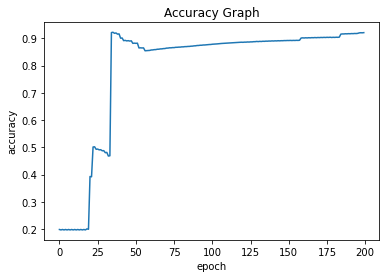

In [2]:
#plot Accuracy Graph
plt.plot(accuracy_history)
plt.title("Accuracy Graph")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()




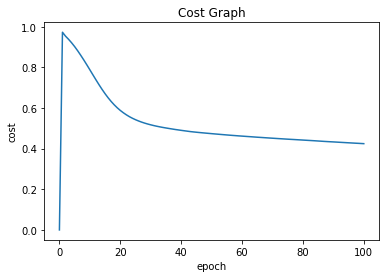

In [3]:
#plot Cost Graph
plt.plot(cost_history)
plt.title("Cost Graph")
plt.xlabel("epoch")
plt.ylabel("cost")
plt.show()


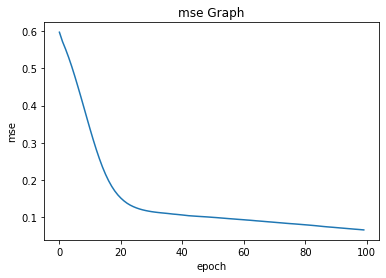

In [4]:
#plot mse Graph
plt.plot(mse_history)
plt.title("mse Graph")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.show()

In [5]:
#print final accuracy

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print ("test accuracy: ", (sess.run(accuracy, feed_dict={x: test_x, y_: test_y})))
            
                              


test accuracy:  0.92043847


In [6]:
#print the final mean sq error
pred_y = sess.run(y, feed_dict={x:test_x})
mse = tf.reduce_mean(tf.square(pred_y) - test_y)                              
print ("Mse: %.4f" % sess.run(mse)) 

Mse: -0.0886


In [7]:
pred_y

array([[0.07495865, 0.9250413 ],
       [0.04833359, 0.95166636],
       [0.3506164 , 0.64938354],
       ...,
       [0.07495866, 0.9250414 ],
       [0.04833359, 0.95166636],
       [0.07495866, 0.9250414 ]], dtype=float32)

In [8]:
test_x

array([[0., 2., 9., ..., 0., 0., 1.],
       [0., 2., 9., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 2., 9., ..., 0., 0., 1.],
       [0., 2., 9., ..., 0., 0., 1.],
       [0., 2., 9., ..., 0., 0., 1.]])


plt.plot(range(len(cost_history)),cost_history)
plt.plot(range(len(accuracy_history)),accuracy_history)
plt.legend(['Cost','Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Cost/Accuracy')
plt.title('Learning Curve')
plt.show()

# Plot mse and accuracy graph
plt.plot(mse_history, 'r')
plt.show()
plt.plot(accuracy_history)
plt.show()

#Once the model is trained, we can apply cross validation

#Define KFold
kf = KFold(n_splits=5)

#Define the KNN model
knn = KNeighborsClassifier(n_neighbors=5)

#loop through the KFold splits
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    #fit the model on the training data
    knn.fit(X_train, y_train)
    
    #predict on the test data
    y_pred = knn.predict(X_test)
    
    #calculate the mean absolute error
    mae = mean_absolute_

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


# Define the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(n_hidden_1, activation='relu', input_shape=(n_dim,)))
model.add(tf.keras.layers.Dense(n_hidden_2, activation='sigmoid'))
model.add(tf.keras.layers.Dense(n_hidden_3, activation='softmax'))
model.add(tf.keras.layers.Dense(n_class, activation='softmax'))

# Save the model to a file
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
